## 모델 동작에 필요한 사전 준비

In [8]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt

from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2023-06-20 23:31:22.205298: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-20 23:31:22.208775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-20 23:31:22.269021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2023-06-20 23:31:22.269058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-20 23:31:22.270958: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-20 23:31:22.271045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

## 데이터 불러오기 및 전처리

In [10]:
# 이번 CycleGAN 실습에 활용될 말과 얼룩말 이미지 데이터를 불러온 후,
# 불러온 데이터를 Training용과 Testing용으로 나누는 과정
# 모든 이미지 데이터의 크기는 256 x 256 x 3 (RGB)

dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info = True, as_supervised = True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

2023-06-20 23:31:25.209047: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Couldn't resolve host 'metadata'".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
# Hyperparameter 값들

BUFFER_SIZE = 1000  # Dataset의 순서를 섞는 과정에서의 Buffer의 크기
BATCH_SIZE = 1      # Training 및 Test 과정에서의 (Mini)Batch의 크기
IMG_HEIGHT = 256    # 조정될 그림의 높이
IMG_WIDTH = 256     # 조정될 그림의 폭

### 이미지 데이터 전처리용 함수

In [12]:
# IMG_HEIGHT x IMG_WIDTH (256 x 256) 크기보다 큰 이미지의 경우
# 이미지 내에서 무작위로 IMG_HEIGHT x IMG_WIDTH 크기만큼의 부분 추출

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size = [IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image



# Data augmentation - 데이터셋의 이미지를 무작위적으로 변환
# 여기서는 이미지의 일부를 무작위로 추출한 후 무작위로 추가적인 좌우 반전 과정을 거침

def random_jitter(image):
    # 256 x 256 x 3 크기의 이미지를 286 x 286 x 3 크기로 조정
    image = tf.image.resize(image, [286, 286], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # 조정된 이미지에서 256 x 256 크기 부분 추출 -> 이미지의 일부가 무작위로 추출 및 확대되는 효과
    image = random_crop(image)

    # 추출해서 얻어진 이미지를 그대로 두거나 좌우 반전
    image = tf.image.random_flip_left_right(image)

    return image



# 이미지 내의 각 픽셀 내의 값을 [-1, 1] 범위로 표준화

def normalize(image):
    image = tf.cast(image, tf.float32)  # 표준화 전: 0 ~ 255 (RGB)
    image = (image / 127.5) - 1         # 표준화 후: -1 ~ 1 (RGB)
    return image

### Training 및 Test 이미지 데이터 전처리 함수

In [13]:
# Training 이미지 데이터만 이미지 변형 (data augmentation) 과정을 거침

def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image



def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [14]:
# 말과 얼룩말 이미지 데이터 전처리
# 전처리 과정에서 이미지의 순서 또한 무작위적으로 섞이게 됨!

train_horses = train_horses.map(preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
train_zebras = train_zebras.map(preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_horses = test_horses.map(preprocess_image_test, num_parallel_calls = AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
test_zebras = test_zebras.map(preprocess_image_test, num_parallel_calls = AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [15]:
# 이미지 예시 확인을 위해 전처리된 Training용 이미지들 중 가장 첫번째 이미지를 불러옴

sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

2023-06-20 23:39:44.906378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-20 23:39:44.924431: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-06-20 23:39:45.856422: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-06-20 23:39:45.861028: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an inp

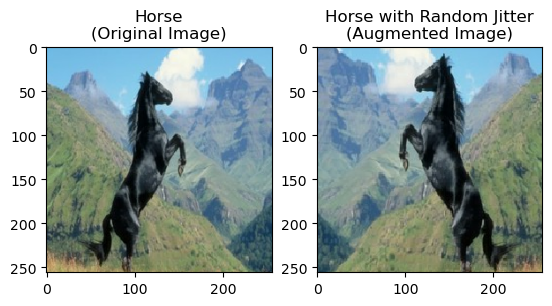

In [16]:
# 말 이미지 예시

plt.subplot(121)
plt.title('Horse\n(Original Image)')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with Random Jitter\n(Augmented Image)')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

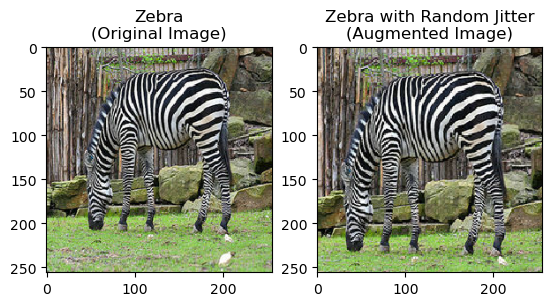

In [17]:
# 얼룩말 이미지 예시

plt.subplot(121)
plt.title('Zebra\n(Original Image)')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with Random Jitter\n(Augmented Image)')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## GAN의 구성 요소 구현

### 이미지와 벡터 사이의 변환 - Downsampling과 Upsampling

In [18]:
# Downsampling: 이미지 -> 벡터
# 매 Downsampling 과장마다 이미지 크기 (가로, 세로 길이)가 절반으로 축소됨

def downsample(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    # 이미지 크기를 절반으로 축소시키는 과정
    # 2D convolutional layer에서 same padding을 적용하고 strides 값을 2로 할 경우 이미지의 크기가 절반으로 줄어드는 효과!
    result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result



# Upsampling: 벡터 -> 이미지
# 매 Upsampling 과정마다 이미지 크기 (가로, 세로 길이) 두 배로 확장됨

def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    # 이미지 크기를 두 배로 확장시키는 과정
    # 2D convolutional layer의 역연산에 해당하는 transposed 2D convolutional layer의 경우,
    # same padding을 적용하고 strides 값을 2로 할 경우 이미지의 크기가 두 배로 확장되는 효과!
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

### GAN의 생성자와 판별자 정의

In [19]:
# GAN의 생성자 (Generator)

def Generator():
    inputs = tf.keras.layers.Input(shape = [256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm = False), # (batch_size, 128, 128, 64)
        downsample(128, 4),                         # (batch_size, 64, 64, 128)
        downsample(256, 4),                         # (batch_size, 32, 32, 256)
        downsample(512, 4),                         # (batch_size, 16, 16, 512)
        downsample(512, 4),                         # (batch_size, 8, 8, 512)
        downsample(512, 4),                         # (batch_size, 4, 4, 512)
        downsample(512, 4),                         # (batch_size, 2, 2, 512)
        downsample(512, 4),                         # (batch_size, 1, 1, 512)
    ]


    # Upsampling의 경우 channel 수가 upsample 함수의 parameter로 제공되는 channel 수의 2배!
    # 이는 upsampling 과정에서는 skip connection을 추가적으로 진행하기 때문 (아래 for문들 참고)
    up_stack = [
        upsample(512, 4, apply_dropout = True),     # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout = True),     # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout = True),     # (batch_size, 8, 8, 1024)
        upsample(512, 4),                           # (batch_size, 16, 16, 1024)
        upsample(256, 4),                           # (batch_size, 32, 32, 512)
        upsample(128, 4),                           # (batch_size, 64, 64, 256)
        upsample(64, 4),                            # (batch_size, 128, 128, 128)
    ]


    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer = initializer, activation = 'tanh')      # (batch_size, 256, 256, 3)

    x = inputs

    # 모델 내에서의 Downsampling 과정
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])


    # 모델 내에서의 Upsampling 과정
    # 이전 정보의 보존을 목적으로 skip connection도 추가
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)


    return tf.keras.Model(inputs = inputs, outputs = x)

In [20]:
# GAN의 판별자 (Discriminator)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = tf.keras.layers.Input(shape = [256, 256, 3], name = 'input_image')

    down1 = downsample(64, 4, False)(inputs)    # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)           # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)           # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)      # (batch_size, 34, 34, 64)
    conv = tf.keras.layers.Conv2D(128, 4, strides = 1, kernel_initializer = initializer, use_bias = False)(zero_pad1)     # (batch_size, 31, 31, 64)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)     # (batch_size, 33, 33, 64)
    last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(zero_pad2)       # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs = inputs, outputs = last)

### CycleGAN 구조 정의

In [21]:
# CycleGAN의 경우 2개의 생성자와 2개의 판별자로 구성됨

generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator()
discriminator_y = Discriminator()

## Training

In [22]:
# Training 과정 관련 hyperparameters

LAMBDA = 10
EPOCHS = 1

In [23]:
# Loss function과 optimizer 정의

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits = True)

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

### Loss Function 정의

In [24]:
# 네 종류의 loss function 정의
# discriminator_loss: GAN의 판별자 관련 loss function
# generator_loss: GAN의 생성자 관련 loss function
# calc_cycled_loss: 한 이미지와 해당 이미지를 두 번 변환시켜 얻어진 이미지 (말 -> 얼룩말 -> 말 or 얼룩말 -> 말 -> 얼룩말) 사이의 loss를 구하는 loss function
# identity_loss: 한 이미지와 해당 이미지를 동일한 이미지로 유지시키게끔 변환시켜 얻어진 이미지 (말 -> 말 or 얼룩말 -> 얼룩말) 사이의 loss를 구하는 loss function

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5


def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1


def identity_loss(real_image, same_image): # cycleGAN을 통해 만들어진 이미지가 아니라, 각각의 GAN 이미지가 만들어낸 
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### Training 과정

In [25]:
def train_step(real_x, real_y):

    # Gradient 계산 과정에서 gradient tape가 여러 번 쓰이기 때문에 persistent를 True로 설정함
    with tf.GradientTape(persistent = True) as tape:
        # x: 말 이미지
        # y: 얼룩말 이미지
        # 생성자 g: 변환 x -> y (말 -> 얼룩말)를 담당
        # 생성자 f: 변환 y -> x (얼룩말 -> 말)를 담당
        # fake: 말 -> 얼룩말 or 얼룩말 -> 말
        # cycled: 말 -> 얼룩말 -> 말 or 얼룩말 -> 말 -> 얼룩말
        # same: 말 -> 말 or 얼룩말 -> 얼룩말

        """
        Generator
        """
        # cycle gan loss    x  ->  y  ->  x
        """fill here"""
        
        # cycle gan loss    y  ->  x  ->  y
        """fill here"""
        
        # Generator's gan loss: x
        """fill here"""
        
        # Generator's loss: y
        """fill here"""
        

        
        """
        Discriminator
        """
        # Discriminator's gan loss: x
        """fill here"""

        # Discriminator's gan loss: y
        """fill here"""

        # Generator loss와 cycle loss 계산
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Total generator loss = adversarial loss (generator loss + identity loss) + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator loss 계산
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # CycleGAN을 구성하는 생성자와 판별자들의 gradient 값들을 계산하는 과정
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # 계산된 gradient 값들을 기반으로 CycleGAN의 생성자와 판별자들을 optimize하는 과정
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [26]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0

    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end = '')
        n+=1

    clear_output(wait = True)

    # Training 과정이 오래 걸리기 때문에, EPOCHS 값을 크게 설정하였을 경우 일정 epoch마다 checkpoint를 생성
    #if (epoch + 1) % 5 == 0:
    #    ckpt_save_path = ckpt_manager.save()
    #    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Time taken for epoch {} is {} sec.\n'.format(epoch + 1, time.time() - start))

Time taken for epoch 1 is 689.7280929088593 sec.



### 이미지 출력용 함수

In [27]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize = (12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Testing

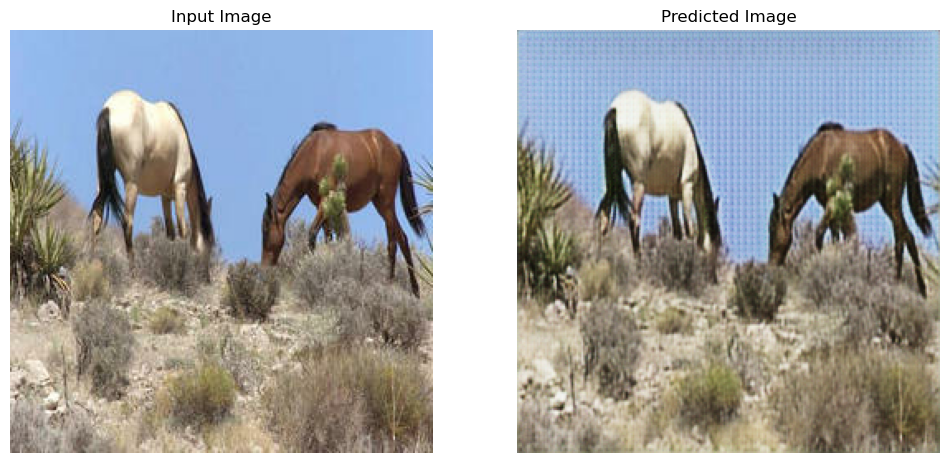

In [28]:
# 학습된 모델을 test data에 적용
# 여기서는 말 이미지 중 첫번째 이미지에 적용

for inp in test_horses.take(1):
    generate_images(generator_g, inp)